In [57]:
import pandas as pd 
from pandas import ExcelWriter
from pandas import ExcelFile
import config
db_name = 'emissions_modelling' 
import seaborn as sns
import matplotlib
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [58]:
df_net = pd.read_excel('Individuals_Internet_2000-2018_Jun2019.xls')
df_net = df_net[['Unnamed: 0', 'Unnamed: 17']]
df_net.rename(columns = {'Unnamed: 0':'country', 'Unnamed: 17': 'internet_percent_pop'}, inplace = True)
df_net = df_net[1:]
df_net = df_net.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [59]:
df_net.head()

,country,internet_percent_pop
1,Afghanistan,11.200000
2,Albania,66.363445
3,Algeria,42.945527
5,Andorra,97.930637
6,Angola,13.000000


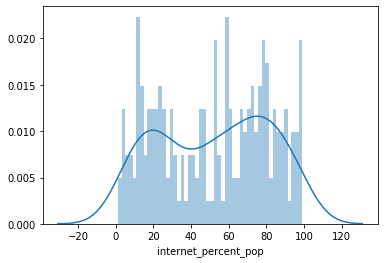

In [60]:
sns.distplot(df_net['internet_percent_pop'], bins = 50)

In [61]:
df_biz = pd.read_excel('API_IC.REG.COST.PC.ZS_DS2_en_excel_v2_323055.xls')
df_biz = df_biz[['Data Source', 'Unnamed: 60']]
df_biz.rename(columns = {'Data Source':'country', 'Unnamed: 60': 'cost_of_biz'}, inplace = True)
df_biz = df_biz[3:]
df_biz = df_biz.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
len(df_biz)

235

In [62]:
df_biz.head()

,country,cost_of_biz
4,Afghanistan,19.900000
5,Angola,20.700000
6,Albania,12.500000
8,Arab World,38.163636
9,United Arab Emirates,13.000000


In [63]:
df_nrg = pd.read_excel('API_EG.USE.COMM.CL.ZS_DS2_en_excel_v2_327403.xls')
df_nrg = df_nrg[['Data Source', 'Unnamed: 58']]
df_nrg.rename(columns = {'Data Source':'country', 'Unnamed: 58': 'perc_renewable_energy'}, inplace = True)
df_nrg = df_nrg[3:]
df_nrg = df_nrg.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [64]:
df_nrg.head()

,country,perc_renewable_energy
5,Angola,2.548840
6,Albania,24.548050
8,Arab World,0.414413
9,United Arab Emirates,0.096907
10,Argentina,5.501504


In [65]:
df = pd.read_csv('thurs_data.csv')

In [66]:
len(df)

115

In [67]:
df = df.merge(df_net, how='inner', on='country')
df = df.merge(df_biz, how='inner', on='country')
df = df.merge(df_nrg, how='inner', on='country')

In [68]:
len(df)

113

In [69]:
df.columns

Index(['Unnamed: 0', 'country', 'gdp_usd', 'population', 'CPI', 'rank',
       'GI_risk', 'co2_mmt', 'gdp_capita', 'regulatory_quality',
       'political_stability', 'accountability', 'rule_of_law',
       'co2_mmt_capita', 'co2_kg_capita', 'GDP_Ag_and_Forest', 'petro_income',
       'resource_income', 'co2_dollar', 'co2_kg_dollar', 'meat_milk_tn',
       'energy_value', 'internet_percent_pop', 'cost_of_biz',
       'perc_renewable_energy'],
      dtype='object')

Select independent variables for second model predicting co2 emissions per dollar of GDP.

In [70]:
df_model = df[['co2_kg_dollar', 'internet_percent_pop', 'GDP_Ag_and_Forest', 'perc_renewable_energy']]

Normalize non-normal independent variables via log transformations.

In [71]:
df_model['GDP_Ag_and_Forest'] = np.log(df_model['GDP_Ag_and_Forest'] + 1)
df_model['perc_renewable_energy'] = np.log(df_model['perc_renewable_energy'] + 1)

/Users/kylebaranko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/kylebaranko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
x_cols = ['GDP_Ag_and_Forest', 'perc_renewable_energy', 'internet_percent_pop']

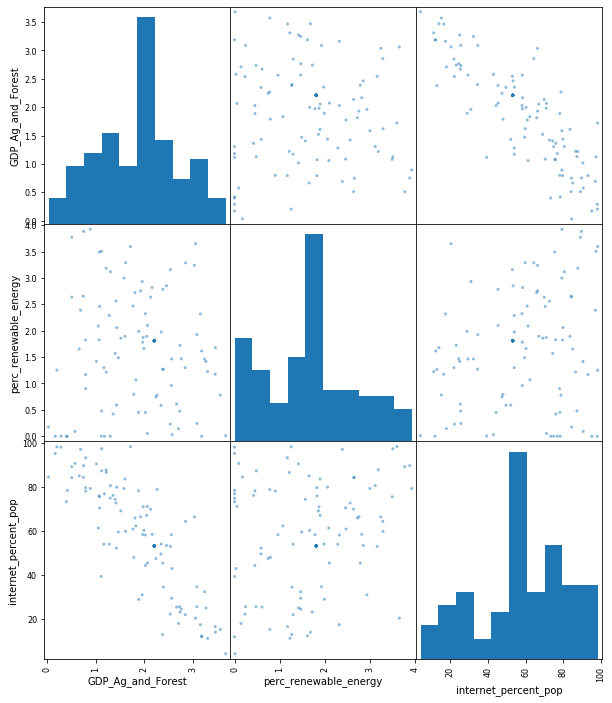

In [73]:
pd.plotting.scatter_matrix(df_model[x_cols], figsize=(10,12));



In [74]:
df_model.corr()

,co2_kg_dollar,internet_percent_pop,GDP_Ag_and_Forest,perc_renewable_energy
co2_kg_dollar,1.000000,0.130521,-0.170392,-0.217682
internet_percent_pop,0.130521,1.000000,-0.843380,0.207353
GDP_Ag_and_Forest,-0.170392,-0.843380,1.000000,-0.033256
perc_renewable_energy,-0.217682,0.207353,-0.033256,1.000000


In [75]:
outcome = 'co2_kg_dollar'
predictors = df_model.drop('co2_kg_dollar', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [76]:
model = ols(formula= formula, data=df_model).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          co2_kg_dollar   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.237
Date:                Fri, 18 Oct 2019   Prob (F-statistic):             0.0251
Time:                        09:21:53   Log-Likelihood:                 35.449
No. Observations:                 113   AIC:                            -62.90
Df Residuals:                     109   BIC:                            -51.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3629      0.143      2.538      0.013       0.080       0.646
internet_percent_pop      0.0008      0.001      0.579      0.564      -0.002       0.004
GDP_Ag_and_Forest        -0.0196      0.039     -0.507      0.613      -0.096       0.057
perc_renewable_energy    -0.0435      0.017     -2.488      0.014      -0.078      -0.009
==============================================================================
Omnibus:                       34.673   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.236
Skew:                           1.372   Prob(JB):                     1.37e-13
Kurtosis:                       5.247   Cond. No.                         543.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared value is very low, suggesting independent variables have little to no effect on outcome. And with correlation matrix below, it is clear that wealth per capita is not correlated with emissions per dollar of GDP. 

In [77]:
df[['gdp_capita', 'co2_kg_dollar']].corr()

,gdp_capita,co2_kg_dollar
gdp_capita,1.000000,0.050769
co2_kg_dollar,0.050769,1.000000


Check relationships with percentage of population in a country using internet as dependent variable. 

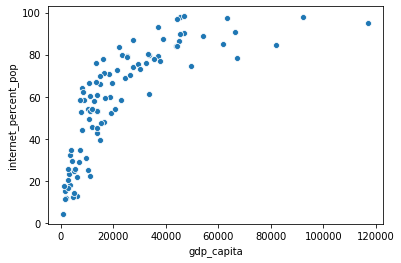

In [78]:
sns.scatterplot(x=df['gdp_capita'], y=df['internet_percent_pop'])

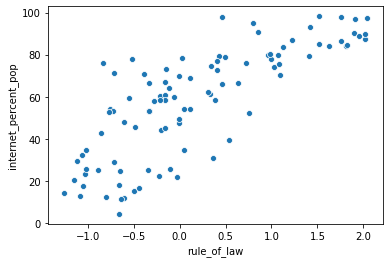

In [79]:
sns.scatterplot(x=df['rule_of_law'], y=df['internet_percent_pop'])

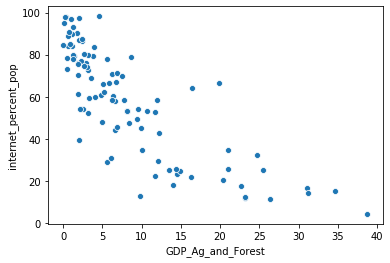

In [80]:
sns.scatterplot(x=df['GDP_Ag_and_Forest'], y=df['internet_percent_pop'])

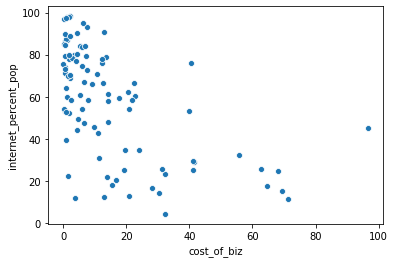

In [81]:
sns.scatterplot(x=df['cost_of_biz'], y=df['internet_percent_pop'])

In [96]:
df_final = df[['internet_percent_pop', 'GDP_Ag_and_Forest', 'accountability', 'cost_of_biz']]
xcols = ['GDP_Ag_and_Forest', 'rule_of_law', 'gdp_capita', 'accountability', 'cost_of_biz']
               
               

Normalize indepedent variables with non-normal distributions via log transformations

In [ ]:
df_final[xcols].corr()

After checking for collinearity, remove rule_of_law from model becuase it is heavily correlated with gdp per capita and accountability. 

Normalize indepedent variables with non-normal distributions via log transformations

In [90]:
df_final['GDP_Ag_and_Forest'] = np.log(df_final['GDP_Ag_and_Forest'] + 1)
df_final['gdp_capita'] = np.log(df_final['gdp_capita'] + 1)

/Users/kylebaranko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/kylebaranko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
df_final[xcols].corr()

,GDP_Ag_and_Forest,gdp_capita,accountability,cost_of_biz
GDP_Ag_and_Forest,1.000000,-0.902681,-0.473695,0.493781
gdp_capita,-0.902681,1.000000,0.374164,-0.585818
accountability,-0.473695,0.374164,1.000000,-0.105209
cost_of_biz,0.493781,-0.585818,-0.105209,1.000000


After checking for collinearity, remove gdp_per_capita because it is heavily correlated with percentage of GDP attributed to agriculture and forestry. 

In [92]:
xcols = ['GDP_Ag_and_Forest', 'accountability', 'cost_of_biz']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c248ce5f8>,
      dtype=object)

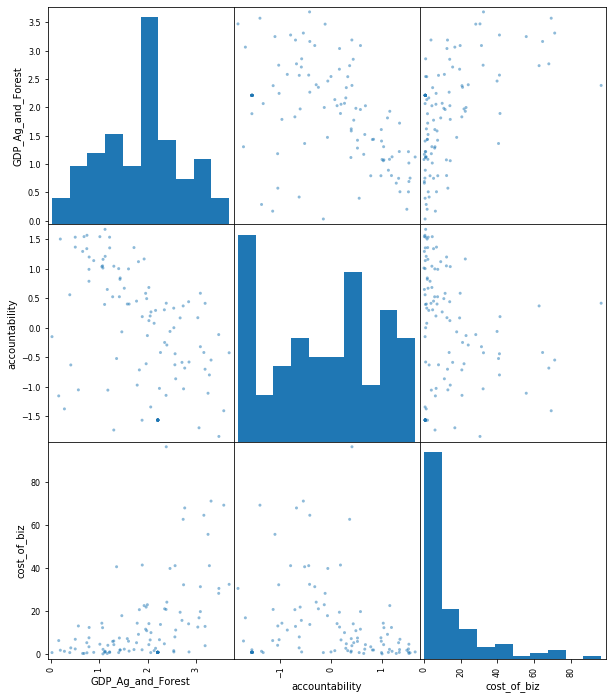

In [93]:
pd.plotting.scatter_matrix(df_final[xcols], figsize=(10,12))

In [97]:
outcome = 'internet_percent_pop'
predictors = df_final.drop('internet_percent_pop', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [98]:
model = ols(formula= formula, data=df_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     internet_percent_pop   R-squared:                       0.677
Model:                              OLS   Adj. R-squared:                  0.669
Method:                   Least Squares   F-statistic:                     76.33
Date:                  Fri, 18 Oct 2019   Prob (F-statistic):           1.14e-26
Time:                          09:51:19   Log-Likelihood:                -455.09
No. Observations:                   113   AIC:                             918.2
Df Residuals:                       109   BIC:                             929.1
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            77.0803      1.937     39.786      0.000      73.241      80.920
GDP_Ag_and_Forest    -2.0074      0.216     -9.295      0.000      -2.435      -1.579
accountability        3.5963      1.358      2.648      0.009       0.905       6.288
cost_of_biz          -0.1875      0.087     -2.158      0.033      -0.360      -0.015
==============================================================================
Omnibus:                        3.823   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.222
Skew:                          -0.383   Prob(JB):                        0.200
Kurtosis:                       3.312   Cond. No.                         36.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After removing indepedent variables exhibiting multicolinearity, model R-squared value increases. 